<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/graph_measures_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weighted graph theory measures on numpy arrays.

This ipynb file aims to define the "Small-Worldness" measure (and other relevant weighted graph measures) for simple numpy array data containers,
in which a numpy array of shape (n_nodes, n_nodes) depicts a weighted network matrix. Hereby the value of matrix[i, j] stands for the strength of the connection (i.e. the weight) between node i and node j.

This code is written in order to analyze brain connectivity data, as for example created by a connectivity measure between different EEG signals. This code especially aims to be easily applicable to [MNE-Python](https://github.com/mne-tools/mne-python) data structures.

This code was created to use for a student study project at the university of Osnabrück and aims to provide a simple and computationally efficient alternative to the [networkx graph toolbox](https://networkx.org).

Most of these functions are derived from Rubinov & Sporns (2010).
If you're interested in these implementations, you may also want to have a look at [bctpy](https://pypi.org/project/bctpy) which is a Python graph theory toolbox that aims to replicate Sporns & Rubinov's brain connectivity toolbox written for MATLAB.

We start with importing the neccessary stuff:

In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data generation
First, we need to generate a fake connectivity matrix / graph. Since we want to compare this graph against random graphs later, we can not simply generate a random matrix, but generate a non-random one.

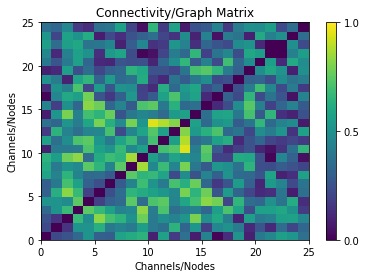

In [45]:
def generate_graph(n_nodes, regularity=0.1):
  # start with a random matrix
  matrix = np.random.rand(n_nodes, n_nodes)

  # make funny patterns:
  for i in range(n_nodes):
    for ii in range(n_nodes):
      if matrix[i, ii] > matrix[i - 3, ii - 13]:
        matrix[i-2:i+2, ii-2:ii+2] += regularity

  # normalize it from 0 to 0.95, as we shouldn't assume that independet signals are perfectly connected.
  matrix /= np.max(matrix) / 0.95

  # make it look like a connectivity matrix
  for i in range(n_nodes):
    for ii in range(n_nodes):
      # mirror it
      matrix[ii, i] = matrix[i,ii]

  matrix = remove_self_connections(matrix)

  return matrix # 1 - matrix!


def remove_self_connections(matrix):
  """Removes the self-connections of a network graph."""
  for i in range(len(matrix)):
    matrix[i, i] = 0
  return matrix


def invert_matrix(matrix):
  """Invert a matrix from 0 to 1, dependent on whether dealing with distances or weight strengths."""
  new_matrix = 1 - matrix.copy()
  return remove_self_connections(new_matrix)


def plot_graph(graph_matrix, title="Connectivity/Graph Matrix", show=True, cb=True):
  plt.pcolormesh(graph_matrix, vmin=0, vmax=1)
  plt.title(title)
  plt.ylabel('Channels/Nodes')
  plt.xlabel('Channels/Nodes')
  if cb:
    plt.colorbar(ticks=[0, .5, 1])
  if show:
    plt.show()
  

plot_graph(generate_graph(n_nodes=25, regularity=0.05))

## Define the graph measures needed for small worldness

If not stated otherwise, all formulas are taken from:

Rubinov & Sporns (2010). Complex network measures of brain connectivity: Uses and interpretations

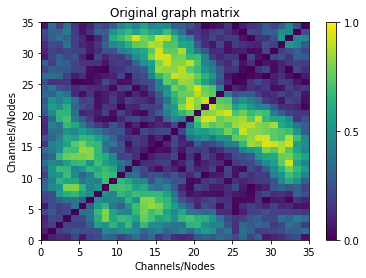

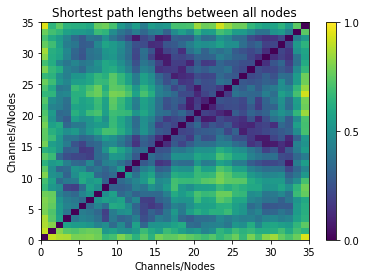

In [46]:
def weighted_shortest_path(matrix):
  """
  Calculate the shortest path lengths between all nodes in a weighted graph.

  This is an implementation of the Floyd-Warshall algorithm for finding the shortest
  path lengths of an entire graph matrix. Implementation taken from:
  https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm

  This implementation is actually identical to scipy.sparse.csgraph.floyd_warshall,
  which we found after the implementation.
  """
  matrix = invert_matrix(matrix)

  n_nodes = len(matrix)
  distances = np.empty([n_nodes, n_nodes])
  for i in range(n_nodes):
    for j in range(n_nodes):
      distances[i,j] = matrix[i, j]
  
  for i in range(n_nodes):
    distances[i,i] = 0

  for k in range(n_nodes):
    for i in range(n_nodes):
      for j in range(n_nodes):
        if distances[i, j] > distances[i, k] + distances[k, j]:
          distances[i, j] = distances[i, k] + distances[k, j]

  return distances


def weighted_characteristic_path_length(matrix):
  """Calculate the characteristic path length for weighted graphs."""
  n_nodes = len(matrix)
  min_distances = weighted_shortest_path(matrix)

  sum_vector = np.empty(n_nodes)
  for i in range(n_nodes):
    # calculate the inner sum
    sum_vector[i] = (1/(n_nodes-1)) * np.sum([min_distances[i, j] for j in range(n_nodes) if j != i])

  return (1/n_nodes) * np.sum(sum_vector)


def weighted_node_degree(matrix):
  """Calculate the node degree for all nodes in a weighted graph."""
  return np.sum(matrix, axis=-1)


def unweighted_node_degree(matrix):
  """Calculate the node degree for all nodes in a weighted graph."""
  return np.sum(np.ceil(matrix), axis=-1)


def weighted_triangle_number(matrix):
  """Calculate the weighted geometric mean of triangles around i for all nodes i in a weighted graph."""
  n_nodes = len(matrix)

  mean_vector = np.empty([n_nodes])
  for i in range(n_nodes):
    triangles = np.array([[matrix[i, j] * matrix[i, k] * matrix[j, k] for j in range(n_nodes)] for k in range(n_nodes)])**(1/3)
    mean_vector[i] = (1/2) * np.sum(triangles, axis=(0,1))
  
  return mean_vector


def weighted_clustering_coeff(matrix):
  """Calculate the clustering coefficient for a weighted graph."""
  n = len(matrix)
  t = weighted_triangle_number(matrix)
  k = unweighted_node_degree(matrix) # here we use the !max possible weights as reference
  return (1/n) * np.sum((2 * t)/(k * (k - 1)))


def weighted_clustering_coeff_z(matrix):
  """Zhang's CC is an alternative clustering coefficient which should work better for our case See Samaräki et al. (2008)."""
  n_nodes = len(matrix)
  ccs = []
  for i in range(n_nodes):
    upper = np.sum([[matrix[i,j] * matrix[j,k] * matrix[i,k] for k in range(n_nodes)] for j in range(n_nodes)])
    lower = np.sum([[matrix[i,j] * matrix[i,k] for k in range(n_nodes) if j!=k] for j in range(n_nodes)])
    ccs.append(upper/lower)

  return np.mean(ccs)
  

# get an intuition for the shortest path length matrix
matrix = generate_graph(n_nodes=35, regularity=0.2)
wsp = weighted_shortest_path(matrix)

plot_graph(matrix, title="Original graph matrix")
plot_graph(wsp, title="Shortest path lengths between all nodes")

## Define random/lattice reference shuffling functions

When dealing with *complete* weighted graphs, we face certain problems when trying to calculate the small world coefficients: All small-world measures compare to random and lattice graphs which are created by shuffling the weights of the original graph. When trying to create a lattice reference graph, we use a markov procedure that allocates weights close to the main diagonal, resulting in a strictly ordered (=lattice) graph. However, usual lattice reference functions (e.g. the one used by networkx) only work for graphs that are not *complete*, i.e. not fully connected. They relocate only existing graph weights to previously non existing edges, which are closer to the diagonal than the original ones. However, when *all* nodes are connected this doesn't work. We adapted the original shuffling algorithm developed by Sporns & Zwi (2004) and implemented in networkx such that *smaller* weights are relocated away from the diagonal, and *larger* weights are allocated towards the diagonal, arguing that smaller weights are closer to being non-existant than larger weights (which in our case of brain connectivity surely holds).

However, we can also use the fact that our graph is complete to make the shuffling algorithm significantly faster (by not having to look for existing nodes first). The fact that we deal on pure numpy arrays also allows faster shuffling than with the high level graph objects used in networkx.

First we define our own random/lattice shuffling functions:

In [47]:
def lattice_reference(G, niter=1, D=None, seed=np.random.seed(np.random.randint(0, 2**30))):
    """Latticize the given graph by swapping edges. Works similar to networkx' lattice reference."""
    from networkx.utils import cumulative_distribution, discrete_sequence

    # Instead of choosing uniformly at random from a generated edge list,
    # this algorithm chooses nonuniformly from the set of nodes with
    # probability weighted by degree.
    G = G.copy()
    keys = [i for i in range(len(G))]
    degrees = weighted_node_degree(G)
    cdf = cumulative_distribution(degrees)  # cdf of degree

    nnodes = len(G)
    nedges = nnodes *(nnodes - 1) // 2 # NOTE: assuming full connectivity
    if D is None:
        D = np.zeros((nnodes, nnodes))
        un = np.arange(1, nnodes)
        um = np.arange(nnodes - 1, 0, -1)
        u = np.append((0,), np.where(un < um, un, um))

        for v in range(int(np.ceil(nnodes / 2))):
            D[nnodes - v - 1, :] = np.append(u[v + 1 :], u[: v + 1])
            D[v, :] = D[nnodes - v - 1, :][::-1]

    niter = niter * nedges
    ntries = int(nnodes * nedges / (nnodes * (nnodes - 1) / 2))
    swapcount = 0

    for i in range(niter):
        n = 0
        while n < ntries:
            # pick two random edges without creating edge list
            # choose source node indices from discrete distribution
            (ai, bi, ci, di) = discrete_sequence(4, cdistribution=cdf, seed=seed)
            if len(set((ai, bi, ci, di))) < 4:
                continue  # picked same node twice
            a = keys[ai]  # convert index to label
            b = keys[bi]
            c = keys[ci]
            d = keys[di]

            is_closer = D[ai, bi] >= D[ci, di]
            is_larger = (G[ai, bi] >= G[ci, di])
            if is_closer and is_larger:
                # only swap if we get closer to the diagonal

                ab = G[a, b]
                cd = G[c, d]
                G[a, b] = cd
                G[b, a] = cd
                G[c, d] = ab
                G[d, c] = ab

                swapcount += 1
                break
            n += 1
    return G


def random_reference(G, niter=1, D=None, seed=np.random.seed(np.random.randint(0, 2**30))):
    """Latticize the given graph by swapping edges. Works similar to networkx' random reference."""
    from networkx.utils import cumulative_distribution, discrete_sequence

    # Instead of choosing uniformly at random from a generated edge list,
    # this algorithm chooses nonuniformly from the set of nodes with
    # probability weighted by degree.
    G = G.copy()
    keys = [i for i in range(len(G))]
    degrees = weighted_node_degree(G)
    cdf = cumulative_distribution(degrees)  # cdf of degree

    nnodes = len(G)
    nedges = nnodes *(nnodes - 1) // 2 # NOTE: assuming full connectivity
    if D is None:
        D = np.zeros((nnodes, nnodes))
        un = np.arange(1, nnodes)
        um = np.arange(nnodes - 1, 0, -1)
        u = np.append((0,), np.where(un < um, un, um))

        for v in range(int(np.ceil(nnodes / 2))):
            D[nnodes - v - 1, :] = np.append(u[v + 1 :], u[: v + 1])
            D[v, :] = D[nnodes - v - 1, :][::-1]

    niter = niter * nedges
    ntries = int(nnodes * nedges / (nnodes * (nnodes - 1) / 2))
    swapcount = 0

    for i in range(niter):
        n = 0
        while n < ntries:
            # pick two random edges without creating edge list
            # choose source node indices from discrete distribution
            (ai, bi, ci, di) = discrete_sequence(4, cdistribution=cdf, seed=seed)
            if len(set((ai, bi, ci, di))) < 4:
                continue  # picked same node twice
            a = keys[ai]  # convert index to label
            b = keys[bi]
            c = keys[ci]
            d = keys[di]


            # only swap if we get closer to the diagonal

            ab = G[a, b]
            cd = G[c, d]
            G[a, b] = cd
            G[b, a] = cd
            G[c, d] = ab
            G[d, c] = ab

            swapcount += 1
            break

    return G

To visualize what our defined random and lattice shuffling does compared to networkx, we plot them next to a (binarized) version of the same graph, shuffled with networkx.



Using our own shuffling functions: 




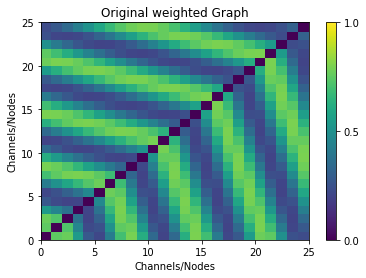

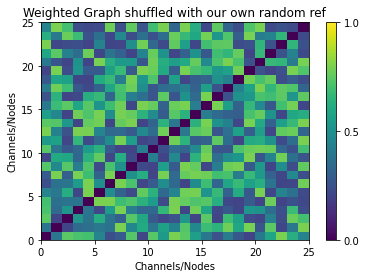

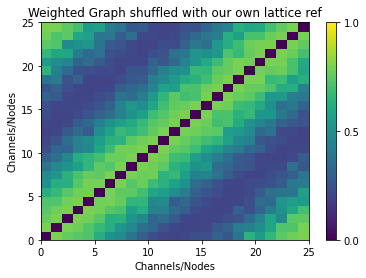



Using networkx on a binarized graph: 




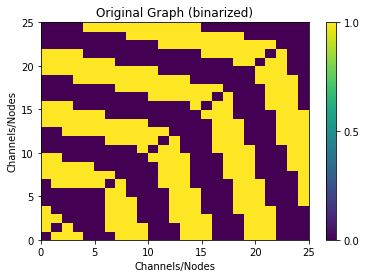

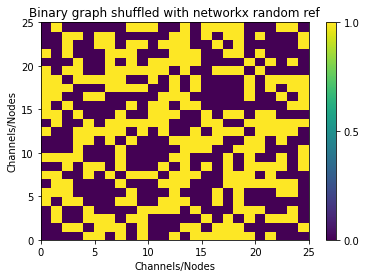

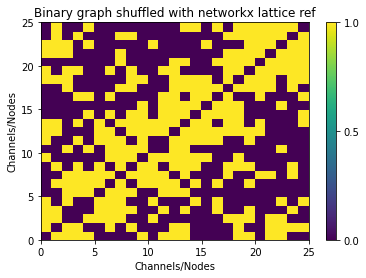

In [48]:
import networkx as nx

def random_reference_nx(matrix, niter=5):
  G = nx.convert_matrix.from_numpy_array(matrix)
  G_ref = nx.algorithms.smallworld.random_reference(G, niter=niter)
  return nx.convert_matrix.to_numpy_array(G_ref)

def lattice_referefnce_nx(matrix, niter=5):
  G = nx.convert_matrix.from_numpy_array(matrix)
  G_ref = nx.algorithms.smallworld.lattice_reference(G, niter=niter)
  return nx.convert_matrix.to_numpy_array(G_ref)

# create a graph with a sin like structure
g = np.vstack([np.sin(np.linspace(i,7+i, 25))*0.3+0.5 for i in range(25)])
# mirror it
for i in range(len(g)):
  for ii in range(len(g)):
    g[i, ii] = g[ii,i]
g = remove_self_connections(g)


# plot actual, random and lattice shuffled graphs side by side
print("\n\nUsing our own shuffling functions: \n\n")
plot_graph(g, title="Original weighted Graph")
plot_graph(random_reference(g, niter=5), title="Weighted Graph shuffled with our own random ref")
plot_graph(lattice_reference(g, niter=5), title="Weighted Graph shuffled with our own lattice ref")


print("\n\nUsing networkx on a binarized graph: \n\n")
plot_graph(g_bin, title="Original Graph (binarized)")
g_bin = np.round(g)
plot_graph(random_reference_nx(g_bin, niter=5), title="Binary graph shuffled with networkx random ref")
plot_graph(lattice_reference_nx(g_bin, niter=5), title="Binary graph shuffled with networkx lattice ref")

## Define Small-Worldness functions

Now we got everything to define our small-worldness functions.

In [49]:
def weighted_sw_sigma(matrix, n_avg=1):
  """Calculate the weighted small world coefficient sigma of a matrix."""
  sigmas = []
  for i in range(n_avg):
    random_graph = random_reference(matrix)
    C = weighted_clustering_coeff_z(matrix)
    C_rand = weighted_clustering_coeff_z(random_graph)
    L = weighted_characteristic_path_length(matrix)
    L_rand = weighted_characteristic_path_length(random_graph)
    sigma = (C/C_rand) / (L/L_rand)
    sigmas.append(sigma)

  return np.mean(sigmas)

def weighted_sw_omega(matrix, n_avg=1):
  """Calculate the weighted small world coefficient omega of a matrix."""
  omegas = []
  for i in range(n_avg):
    random_graph = random_reference(matrix)
    lattice_graph = lattice_reference(matrix)
    C = weighted_clustering_coeff_z(matrix)
    C_latt = weighted_clustering_coeff_z(lattice_graph)
    L = weighted_characteristic_path_length(matrix)
    L_rand = weighted_characteristic_path_length(random_graph)
    omega = (L_rand/L) / (C/C_latt)
    omegas.append(omega)

  return np.mean(omegas)


def weighted_sw_index(matrix, n_avg=1):
  """Calculate the weighted small world coefficient omega of a matrix."""
  indices = []
  for i in range(n_avg):
    random_graph = random_reference(matrix)
    lattice_graph = lattice_reference(matrix)
    C = weighted_clustering_coeff_z(matrix)
    C_rand = weighted_clustering_coeff_z(random_graph)
    C_latt = weighted_clustering_coeff_z(lattice_graph)
    L = weighted_characteristic_path_length(matrix)
    L_rand = weighted_characteristic_path_length(random_graph)
    L_latt = weighted_characteristic_path_length(lattice_graph)
    index = ((L - L_latt) / (L_rand - L_latt)) * ((C - C_rand) / (C_latt - C_rand))
    indices.append(index)
  return np.mean(indices)

## Measure Small-Worldness

Feel free to play around a little bit.

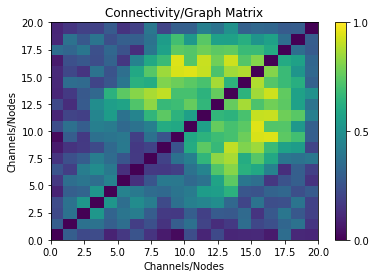

Small worldness coefficient:  0.8355098348216147

Multiple small world measures of the same network graph:

 [0.88443673 0.86865593 0.87885048 0.88398869 0.87829326 0.87051095
 0.88301246 0.87995413 0.86354839 0.88236722]


In [50]:
# generate a new graph
graph = generate_graph(n_nodes=20, regularity=0.15)

# plot it
plot_graph(graph)


# now we can calculate the small worldness of this one
small_world = weighted_sw_sigma(graph)
print("Small worldness coefficient: ", small_world)


# actually we can calculate the small worldness multiple times and see how much the random graph affects the outcome.
small_world_list = np.array([weighted_sw_sigma(graph, 10) for i in range(10)])
print("\nMultiple small world measures of the same network graph:\n\n", small_world_list)

As we can see, the small worldness measure has quite some variance in it. We should probably calculate it multiple times and average!

## Other Graph measures
Define some other graph measures that are interesting.

In [51]:

def weighted_global_efficiency(matrix):
  """The weighted global efficiency is closely related to the characteristic path length."""
  n_nodes = len(matrix)
  min_distances = weighted_shortest_path(matrix)

  sum_vector = np.empty(n_nodes)
  for i in range(n_nodes):
    # calculate the inner sum
    sum_vector[i] = (1/(n_nodes-1)) * np.sum([1 / min_distances[i, j] for j in range(n_nodes) if j != i])

  return (1/n_nodes) * np.sum(sum_vector)


def weighted_transitivity(matrix):
  """The transitivity is related to the clustering coefficient."""
  
  n = len(matrix)
  t = weighted_triangle_number(matrix)
  k = unweighted_node_degree(matrix) # here we use the max possible weights as reference
  
  return np.sum(2 * t) / np.sum(k * (k - 1))


## Compare Small-World coefficient with other graph measures
Calculate all interesting measures on a set of graphs and check their correlation.

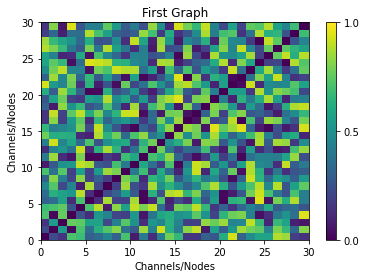

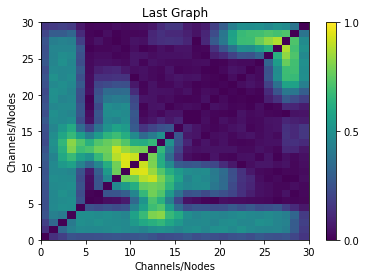

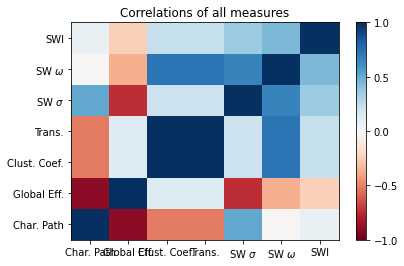

[[ 1.         -0.89587379 -0.51657186 -0.51657186  0.51961655 -0.01364881
   0.07509898]
 [-0.89587379  1.          0.13466635  0.13466635 -0.73441356 -0.36105858
  -0.23534892]
 [-0.51657186  0.13466635  1.          1.          0.21641263  0.72794409
   0.23486155]
 [-0.51657186  0.13466635  1.          1.          0.21641263  0.72794409
   0.23486155]
 [ 0.51961655 -0.73441356  0.21641263  0.21641263  1.          0.66541898
   0.36286005]
 [-0.01364881 -0.36105858  0.72794409  0.72794409  0.66541898  1.
   0.44968277]
 [ 0.07509898 -0.23534892  0.23486155  0.23486155  0.36286005  0.44968277
   1.        ]]


In [52]:
# first generate multiple graphs to compare
graphs = [generate_graph(n_nodes=30, regularity=0.01*i) for i in range(100)]

# plot some of them
plot_graph(graphs[0], "First Graph")
plot_graph(graphs[-1], "Last Graph")


# calculate different graph measures
characteristic_paths =  [weighted_characteristic_path_length(graph) for graph in graphs]
global_efficiencies =   [weighted_global_efficiency(graph) for graph in graphs]
clustering_coeffs =     [weighted_clustering_coeff(graph) for graph in graphs]
transitivities =        [weighted_transitivity(graph) for graph in graphs]
sw_sigma =      [weighted_sw_sigma(graph, n_avg=3) for graph in graphs]
sw_omega =      [weighted_sw_omega(graph, n_avg=3) for graph in graphs]
sw_index =      [weighted_sw_index(graph, n_avg=3) for graph in graphs]


# concatenate them and put them into a correlation matrix
measures = np.vstack([characteristic_paths, global_efficiencies,
                      clustering_coeffs, transitivities,
                      sw_sigma, sw_omega, sw_index])
corr_matrix = np.corrcoef(measures)


# plot the results
plt.pcolormesh(corr_matrix, vmin=-1, vmax=1, cmap="RdBu")
plt.title("Correlations of all measures")
labels = ["Char. Path", "Global Eff.", "Clust. Coef.", "Trans.", 
          "SW $\sigma$", "SW $\omega$", "SWI"]
ax = plt.gca()
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xticks(np.arange(len(labels))+0.5)
plt.yticks(np.arange(len(labels))+0.5)
plt.colorbar(ticks=[-1, -.5, 0, .5, 1])
plt.show()

# also print the numbers
print(corr_matrix)



##Literature:


Rubinov, M., & Sporns, O. (2010). Complex network measures of brain connectivity: uses and interpretations. Neuroimage, 52(3), 1059-1069.

Saramäki, J., Kivelä, M., Onnela, J. P., Kaski, K., & Kertesz, J. (2007). Generalizations of the clustering coefficient to weighted complex networks. Physical Review E, 75(2), 027105.

Sporns, O., & Zwi, J. D. (2004). The small world of the cerebral cortex. Neuroinformatics, 2(2), 145-162.